# Hierarchical Temporal Encoder Training on Google Colab

This notebook trains the **Hierarchical Temporal Encoder** for multi-scale energy system graphs.

## Architecture Overview

```
ENCODER (Bottom-Up)
  Assets (604 nodes)  → Sparse GAT  → Pooling
  Zones (100 nodes)   → Sparse GAT  → Pooling  
  Regions (10 nodes)  → Sparse GAT  → Pooling
  Nation (1 node)     → Temporal Transformer (Dense)

DECODER (Top-Down)
  Nation → Regions → Zones → Assets
  (with skip connections at each level)
```

## Memory Efficiency

- **Sparse GAT** on large graphs (604, 100, 10 nodes)
- **Dense Transformer** only on Nation level (1 node × 96 timesteps)
- **Estimated memory**: 3-8 GB (vs 40+ GB for dense HGT)

## Setup Requirements

- **GPU**: A100 (40GB or 80GB), V100, or T4
- **Runtime**: Python 3.10+
- **Google Drive**: Repository at `/content/drive/MyDrive/benchmark`

## 1. Mount Google Drive

In [1]:
from google.colab import drive
import os
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# Set repository path
REPO_PATH = Path('/content/drive/MyDrive/benchmark')

# Change to repository directory
os.chdir(REPO_PATH)

print(f"✅ Google Drive mounted successfully!")
print(f"📁 Repository path: {REPO_PATH}")
print(f"📁 Current directory: {os.getcwd()}")
print(f"\n📂 Repository structure:")
print(f"   - src/ exists: {(REPO_PATH / 'src').exists()}")
print(f"   - outputs/ exists: {(REPO_PATH / 'outputs').exists()}")
print(f"   - outputs/graphs/ exists: {(REPO_PATH / 'outputs' / 'graphs').exists()}")

if not (REPO_PATH / 'src').exists():
    raise RuntimeError(
        f"❌ Repository not found at {REPO_PATH}\n"
        "Please ensure your 'benchmark' folder is in Google Drive at:\n"
        "/content/drive/MyDrive/benchmark"
    )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
📁 Repository path: /content/drive/MyDrive/benchmark
📁 Current directory: /content/drive/MyDrive/benchmark

📂 Repository structure:
   - src/ exists: True
   - outputs/ exists: True
   - outputs/graphs/ exists: True


## 2. Verify GPU

In [2]:
import torch

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("⚠️ WARNING: No GPU detected! Please enable GPU in Runtime > Change runtime type")

PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
GPU Device: NVIDIA A100-SXM4-40GB
GPU Memory: 42.47 GB
Number of GPUs: 1


## 3. Install Dependencies

In [3]:
import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q numpy scipy tqdm matplotlib seaborn pandas

print("\n✅ All dependencies installed!")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 146.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 120.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 142.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8

## 4. Verify Dataset & Extract Hierarchy

In [3]:
import json
from pathlib import Path
import numpy as np
import torch

# Check dataset
data_dir = REPO_PATH / 'outputs/graphs/hetero_temporal_v1'
index_path = data_dir / 'dataset_index.json'

if not index_path.exists():
    raise FileNotFoundError(f"Dataset index not found at {index_path}")

# Load index
with open(index_path, 'r') as f:
    index_data = json.load(f)

print(f"✅ Dataset found!")
print(f"Total graphs: {len(index_data['entries'])}")

# Load first graph to extract hierarchy
first_graph_rel = index_data['entries'][0]['graph_file'].replace('\\', '/')
first_graph = REPO_PATH / first_graph_rel

if not first_graph.exists():
    raise FileNotFoundError(f"First graph file not found at {first_graph}")

sample = np.load(first_graph, allow_pickle=True)
print(f"\n📊 Sample graph info:")
print(f"  - Node features shape: {sample['node_features'].shape}")
print(f"  - Edge index shape: {sample['edge_index'].shape}")
print(f"  - Node types shape: {sample['node_types'].shape}")

node_feature_dim = sample['node_features'].shape[1]
meta = sample['meta'].item()
N_base = meta['N_base']
T_sample = meta['T']

print(f"\n📊 Dataset Info:")
print(f"  - Node feature dim: {node_feature_dim}")
print(f"  - N_base: {N_base}")
print(f"  - T: {T_sample}")

# Extract node types from base graph (first N_base nodes)
node_types_base = sample['node_types'][:N_base]
unique_types, counts = np.unique(node_types_base, return_counts=True)

print(f"\n🏗️ Node Type Distribution (base graph):")
type_names = {0: "Nation", 1: "Region", 2: "Zone", 3: "Asset", 4: "Weather"}
for nt, count in zip(unique_types, counts):
    print(f"  - Type {nt} ({type_names.get(nt, 'Unknown')}): {count} nodes")

# ===== EXTRACT REAL HIERARCHY FROM GRAPH STRUCTURE =====

# 1. Zone → Region mapping (from zone_region_index in graph)
zone_region_mapping = torch.from_numpy(sample['zone_region_index']).long()
print(f"\n✅ Zone→Region mapping extracted from graph")
print(f"   Shape: {zone_region_mapping.shape}")
print(f"   Unique regions: {zone_region_mapping.unique().tolist()}")

# 2. Asset → Zone mapping (from edges)
# Assets connect to zones via hierarchy edges (edge_type 0-6 are spatial)
edge_index = sample['edge_index']
edge_types = sample['edge_types']
node_types_full = sample['node_types']  # All nodes including temporal

# Find hierarchy edges (types 0-6 are spatial hierarchy edges)
spatial_mask = edge_types < 7
spatial_edges = edge_index[:, spatial_mask]

# Extract base graph edges (within first N_base*T nodes, but map to base)
base_node_mask = spatial_edges[0] < (N_base * T_sample)
base_edges = spatial_edges[:, base_node_mask]

# Map to base node indices (remove temporal dimension)
base_edges_mapped = base_edges % N_base

# Find asset→zone connections
# Assets (type 3) should connect to Zones (type 2)
asset_mask_base = node_types_base == 3
zone_mask_base = node_types_base == 2

# Create asset→zone mapping
num_assets = asset_mask_base.sum().item()
num_zones = zone_mask_base.sum().item()

asset_to_zone = torch.zeros(N_base, dtype=torch.long)
zone_indices = torch.where(torch.from_numpy(zone_mask_base))[0] # Fixed: Convert numpy array to tensor

# For each asset, find its parent zone via edges
for asset_idx in torch.where(torch.from_numpy(asset_mask_base))[0]: # Fix: convert asset_mask_base to tensor
    # Find edges where this asset is the source
    outgoing_mask = base_edges_mapped[0] == asset_idx
    if outgoing_mask.any():
        targets = base_edges_mapped[1, outgoing_mask]
        # Find which targets are zones
        # Ensure zone_mask_base is applied to a tensor, and targets is converted if needed
        zone_targets = targets[torch.from_numpy(zone_mask_base[targets])]
        if len(zone_targets) > 0:
            # Map to zone list index (0 to num_zones-1)
            zone_node_id = zone_targets[0].item()
            zone_list_idx = (zone_indices == zone_node_id).nonzero(as_tuple=True)[0]
            if len(zone_list_idx) > 0:
                asset_to_zone[asset_idx] = zone_list_idx[0]

# For non-asset nodes, assign to first zone (fallback)
asset_to_zone[~asset_mask_base] = 0

print(f"\n✅ Asset→Zone mapping extracted from edges")
print(f"   Shape: {asset_to_zone.shape}")
print(f"   Assets mapped to {asset_to_zone[asset_mask_base].unique().numel()} unique zones")

# Create final hierarchy mapping
hierarchy_mapping = {
    'asset_to_zone': asset_to_zone,
    'zone_to_region': zone_region_mapping,
}

print(f"\n✅ Hierarchy mappings created!")
print(f"  - asset_to_zone shape: {asset_to_zone.shape}")
print(f"  - zone_to_region shape: {zone_region_mapping.shape}")
print(f"  - Regions: {zone_region_mapping.unique().tolist()}")

✅ Dataset found!
Total graphs: 2960

📊 Sample graph info:
  - Node features shape: (8112, 14)
  - Edge index shape: (2, 9031)
  - Node types shape: (8112,)

📊 Dataset Info:
  - Node feature dim: 14
  - N_base: 338
  - T: 24

🏗️ Node Type Distribution (base graph):
  - Type 0 (Nation): 1 nodes
  - Type 1 (Region): 9 nodes
  - Type 2 (Zone): 52 nodes
  - Type 3 (Asset): 267 nodes
  - Type 4 (Weather): 9 nodes

✅ Zone→Region mapping extracted from graph
   Shape: torch.Size([52])
   Unique regions: [1, 2, 3, 4, 5, 6, 7, 8, 9]

✅ Asset→Zone mapping extracted from edges
   Shape: torch.Size([338])
   Assets mapped to 1 unique zones

✅ Hierarchy mappings created!
  - asset_to_zone shape: torch.Size([338])
  - zone_to_region shape: torch.Size([52])
  - Regions: [1, 2, 3, 4, 5, 6, 7, 8, 9]


## 5. Configuration

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    """Training configuration for Hierarchical Temporal Encoder"""

    # Data (Google Drive paths)
    repo_path: str = '/content/drive/MyDrive/benchmark'
    data_dir: str = '/content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v1'
    train_split: float = 0.8

    # Model architecture - OPTIMIZED for 604 nodes
    hidden_dim: int = 128           # Rich embeddings
    num_spatial_layers: int = 2     # 2 layers per hierarchy level
    num_temporal_layers: int = 4    # Dense temporal at top
    num_heads: int = 8              # Multi-head attention
    dropout: float = 0.1

    # Training
    loss_type: str = 'multilag'
    epochs: int = 150
    batch_size: int = 1             # 1 graph at a time
    lr: float = 1.5e-4
    weight_decay: float = 1e-5
    grad_clip: float = 1.0
    warmup_epochs: int = 10

    # Loss hyperparams (for contrastive learning)
    max_nodes: int = 512            # Subsample nodes in loss if needed
    neg_sample_ratio: float = 0.1   # Ratio of negatives to sample
    temperature: float = 0.07

    # Output (Google Drive paths)
    save_dir: str = '/content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal'
    save_embeddings: bool = True
    save_freq: int = 10

    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers: int = 0

config = TrainingConfig()

print("📋 Training Configuration:")
print(f"  Repo path: {config.repo_path}")
print(f"  Model: Hierarchical Temporal Encoder")
print(f"  Hidden dim: {config.hidden_dim}")
print(f"  Spatial layers: {config.num_spatial_layers} (per level)")
print(f"  Temporal layers: {config.num_temporal_layers} (at Nation level)")
print(f"  Attention heads: {config.num_heads}")
print(f"  Batch size: {config.batch_size}")
print(f"  Device: {config.device}")
print(f"  Save directory: {config.save_dir}")
print(f"\n💾 Estimated memory: ~5-8 GB (vs 40+ GB for dense HGT)")

📋 Training Configuration:
  Repo path: /content/drive/MyDrive/benchmark
  Model: Hierarchical Temporal Encoder
  Hidden dim: 128
  Spatial layers: 2 (per level)
  Temporal layers: 4 (at Nation level)
  Attention heads: 8
  Batch size: 1
  Device: cuda
  Save directory: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal

💾 Estimated memory: ~5-8 GB (vs 40+ GB for dense HGT)


In [5]:
import torch

def get_hierarchy_from_batch(batch, device):
    """
    Returns a dict with:
      - asset_to_zone: LongTensor [N_assets]
      - zone_to_region: LongTensor [N_zones]
    Priority:
      1) direct attributes on batch (recommended)
      2) packed hierarchy_mapping on batch
      3) raise a clear error (better than silent wrong mapping)
    """
    # Case 1: explicit tensors on batch
    if hasattr(batch, "asset_to_zone") and hasattr(batch, "zone_to_region"):
        return {
            "asset_to_zone": batch.asset_to_zone.to(device),
            "zone_to_region": batch.zone_to_region.to(device),
        }

    # Case 2: packed mapping
    if hasattr(batch, "hierarchy_mapping") and batch.hierarchy_mapping is not None:
        hm = batch.hierarchy_mapping
        return {
            "asset_to_zone": hm["asset_to_zone"].to(device),
            "zone_to_region": hm["zone_to_region"].to(device),
        }

    # If you reach here, don't do modulo hacks — fail loudly
    raise RuntimeError(
        "❌ No hierarchy mapping found in batch. "
        "Please store asset_to_zone and zone_to_region in each graph object during dataset creation."
    )


## 6. Load Model & Create Dataset

In [6]:
import sys
from pathlib import Path
import json
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

# Set seed
SEED = 42

# Add repo path to sys.path (Google Drive)
REPO_ROOT = Path('/content/drive/MyDrive/benchmark')
sys.path.insert(0, str(REPO_ROOT))

print(f"📦 Adding to sys.path: {REPO_ROOT}")

# Import model and dataset
from src.gnn.models.hierarchical_temporal_encoder import HierarchicalTemporalEncoder
from src.gnn.models.temporal_hetero_gnn import TemporalGraphDataset

print("✅ Model imported successfully!")

# Load dataset
print("\nLoading dataset...")
data_dir = Path(config.data_dir)
index_path = data_dir / "dataset_index.json"

with open(index_path, 'r') as f:
    index_data = json.load(f)

# Build graph file paths
graph_files = []
for e in index_data["entries"]:
    rel_path = e["graph_file"].replace('\\', '/')
    graph_files.append(REPO_ROOT / rel_path)

print(f"Found {len(graph_files)} graphs")

# Create dataset
dataset = TemporalGraphDataset(graph_files, target_indices=None)

g = torch.Generator().manual_seed(SEED)

train_size = int(config.train_split * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=g)

# Sauvegarde des indices réels (super utile pour reproduire + paper)
split_path = Path(config.data_dir) / f"split_seed{SEED}_train{train_size}_val{val_size}.json"
split_payload = {
    "seed": SEED,
    "train_size": train_size,
    "val_size": val_size,
    "train_indices": train_dataset.indices,
    "val_indices": val_dataset.indices,
}
split_path.write_text(json.dumps(split_payload, indent=2))
print(f"✅ Split saved to: {split_path}")


# Create loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=False
)

print("📊 Calcul des statistiques de normalisation sur le train set...")


indices_sample = torch.randperm(len(train_dataset))
all_features_list = []

for idx in indices_sample:
    # On accède directement au dataset sans passer par le loader pour éviter le batching
    data_sample = train_dataset[idx]
    if hasattr(data_sample, 'x') and data_sample.x is not None:
        all_features_list.append(data_sample.x)

# Concaténer tout pour calculer mean/std global
all_features_tensor = torch.cat(all_features_list, dim=0)
train_mean = all_features_tensor.mean(dim=0)
train_std = all_features_tensor.std(dim=0)

# Sécurité : remplacer 0 par 1 dans std pour éviter division par zéro
train_std = torch.where(train_std < 1e-6, torch.ones_like(train_std), train_std)

print(f"✅ Statistiques calculées !")
print(f"   Moyenne (4 premières dim) : {train_mean[:4]}")
print(f"   Ecart-type (4 premières dim) : {train_std[:4]}")

# On envoie ces constantes sur le GPU pour qu'elles soient prêtes
train_mean = train_mean.to(config.device)
train_std = train_std.to(config.device)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

📦 Adding to sys.path: /content/drive/MyDrive/benchmark
✅ Model imported successfully!

Loading dataset...
Found 2960 graphs
✅ Split saved to: /content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v1/split_seed42_train2368_val592.json
📊 Calcul des statistiques de normalisation sur le train set...
✅ Statistiques calculées !
   Moyenne (4 premières dim) : tensor([166.2826,  71.0220,  85.5723,  65.7777])
   Ecart-type (4 premières dim) : tensor([428.5510, 393.3297, 558.4737, 450.3384])
Train batches: 2368
Val batches: 592


## 7. Create Model

In [7]:
import gc

# Create model
print("🔨 Creating Hierarchical Temporal Encoder...")

model = HierarchicalTemporalEncoder(
    node_feature_dim=node_feature_dim,
    hidden_dim=config.hidden_dim,
    num_spatial_layers=config.num_spatial_layers,
    num_temporal_layers=config.num_temporal_layers,
    num_heads=config.num_heads,
    dropout=config.dropout,
)

model = model.to(config.device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.2f} MB (FP32)")

# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay,
    betas=(0.9, 0.999),
)

print(f"\n✅ Optimizer: AdamW")
print(f"   Learning rate: {config.lr}")
print(f"   Weight decay: {config.weight_decay}")

# Create scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_epochs, num_epochs):
    """Cosine annealing with linear warmup"""
    def lr_lambda(epoch):
        # epoch is 0-based when called by LambdaLR
        if epoch < num_warmup_epochs:
            return float(epoch + 1) / float(max(1, num_warmup_epochs))
        progress = float(epoch - num_warmup_epochs) / float(max(1, num_epochs - num_warmup_epochs))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))


    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

import math
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_epochs=config.warmup_epochs,
    num_epochs=config.epochs
)

print(f"\n✅ Scheduler: Cosine Annealing with Warmup")
print(f"   Warmup epochs: {config.warmup_epochs}")
print(f"   Total epochs: {config.epochs}")

# Memory info
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f"\n💾 GPU Memory:")
    print(f"   Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"   Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    print(f"   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9:.2f} GB")

🔨 Creating Hierarchical Temporal Encoder...
✅ Model created!
   Total parameters: 3,185,664
   Trainable parameters: 3,185,664
   Model size: ~12.74 MB (FP32)

✅ Optimizer: AdamW
   Learning rate: 0.00015
   Weight decay: 1e-05

✅ Scheduler: Cosine Annealing with Warmup
   Warmup epochs: 10
   Total epochs: 150

💾 GPU Memory:
   Allocated: 0.01 GB
   Reserved: 0.01 GB
   Free: 42.46 GB


## 8. Loss Functions

In [8]:
import torch
import torch.nn.functional as F

def contrastive_loss_multilag(
    embeddings,
    lags=(1, 4, 8),
    neg_sample_ratio=0.10,
    max_nodes=160,
    temperature=0.20,
    logits_clamp=50.0,
    eps=1e-8,
):
    """
    Canonical multi-lag InfoNCE loss for temporal node embeddings.

    Args:
        embeddings: Tensor [N, T, D] or dict with embeddings['assets'] = [N, T, D]
        lags: positive time offsets
        neg_sample_ratio: n_neg = max(128, int(M * neg_sample_ratio))
        max_nodes: subsample nodes for stability/speed
        temperature: softmax temperature
        logits_clamp: clamp logits to [-logits_clamp, logits_clamp] to prevent overflow
        eps: epsilon for safe normalization

    Returns:
        scalar loss (Tensor)
    """
    # --- unwrap ---
    if isinstance(embeddings, dict):
        if "assets" not in embeddings:
            raise KeyError("Expected embeddings['assets'] for dict input.")
        embeddings = embeddings["assets"]

    if embeddings.dim() != 3:
        raise ValueError(f"Expected embeddings of shape [N,T,D], got {tuple(embeddings.shape)}")

    N, T, D = embeddings.shape
    device = embeddings.device

    # --- subsample nodes ---
    if N > max_nodes:
        idx = torch.randperm(N, device=device)[:max_nodes]
        embeddings = embeddings[idx]
        N = max_nodes

    # --- safe L2 normalize ---
    emb = embeddings / embeddings.norm(dim=-1, keepdim=True).clamp_min(eps)  # [N,T,D]

    # --- build anchor/positive pairs across lags ---
    anchor_chunks = []
    pos_chunks = []
    valid_lags = [lag for lag in lags if 0 < lag < T]

    if len(valid_lags) == 0:
        # No valid positives -> return 0 (or raise). Returning 0 is safer for long runs.
        return torch.zeros([], device=device, dtype=embeddings.dtype)

    for lag in valid_lags:
        a = emb[:, :T - lag, :].reshape(-1, D)  # [N*(T-lag), D]
        p = emb[:, lag:, :].reshape(-1, D)
        anchor_chunks.append(a)
        pos_chunks.append(p)

    anchors = torch.cat(anchor_chunks, dim=0)     # [M, D]
    positives = torch.cat(pos_chunks, dim=0)      # [M, D]
    M = anchors.size(0)

    # --- sample negatives from pooled (node,time) embeddings ---
    pool = emb.reshape(N * T, D)                  # [N*T, D]
    n_neg = max(128, int(M * neg_sample_ratio))
    neg_idx = torch.randint(0, N * T, (n_neg,), device=device)
    negatives = pool[neg_idx]                     # [n_neg, D]

    # --- logits ---
    # Positive: dot(anchor, positive)
    pos_logits = (anchors * positives).sum(dim=-1, keepdim=True) / temperature  # [M,1]
    # Negatives: anchor @ negatives^T
    neg_logits = (anchors @ negatives.t()) / temperature                         # [M,n_neg]
    logits = torch.cat([pos_logits, neg_logits], dim=1)                          # [M,1+n_neg]

    # --- numerical safety ---
    if logits_clamp is not None:
        logits = logits.clamp(-logits_clamp, logits_clamp)

    labels = torch.zeros(M, dtype=torch.long, device=device)  # positive at index 0

    return F.cross_entropy(logits, labels)


print("✅ Loss function defined: contrastive_loss_multilag")


✅ Loss function defined: contrastive_loss_multilag


## 9. Training Loop

In [9]:
from tqdm.notebook import tqdm
import time
import torch
from torch.utils.checkpoint import checkpoint
from torch_geometric.utils import add_self_loops

def train_epoch(model, loader, optimizer, device, accumulation_steps=4):
    model.train()
    total_loss = 0.0
    num_batches = 0

    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(loader, desc="Training", leave=False)
    for i, batch in enumerate(pbar):
        batch = batch.to(device)

        if hasattr(batch, 'x') and batch.x is not None:
            batch.x = (batch.x - train_mean) / train_std

        # Robust node count
        # If batch.x is [num_nodes, feat_dim]
        N_total = batch.x.size(0) if hasattr(batch, "x") and batch.x is not None else batch.num_nodes

        # Your N_base and T logic (keep your own if correct)
        N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
        T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()

        # ✅ Always use real hierarchy from batch
        current_hierarchy = get_hierarchy_from_batch(batch, device)

        # Self-loops: use N_total if your edge_index spans all nodes
        edge_index_with_loops, _ = add_self_loops(batch.edge_index, num_nodes=N_total)

        with torch.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            embeddings = model(
                batch.x,
                edge_index_with_loops,
                batch.node_type if hasattr(batch, "node_type") else None,
                N_base,
                T,
                hierarchy_mapping=current_hierarchy,
                zone_edges=None,
                region_edges=None,
                batch=None,
                return_sequence=True,
            )

            # After forward
            E = embeddings["assets"] if isinstance(embeddings, dict) else embeddings
            E = E.float()

            if torch.isnan(E).any() or torch.isinf(E).any():
                print("❌ NaN/Inf in embeddings (train).")
                print("E stats:", E.min().item(), E.mean().item(), E.max().item())
                raise RuntimeError("NaN/Inf in embeddings")

        E = embeddings["assets"].float() if isinstance(embeddings, dict) else embeddings.float()

        loss = contrastive_loss_multilag(
                E,
                lags=(1, 4, 8),
                neg_sample_ratio=0.25,
                max_nodes=160,   # tune
                temperature=0.10
            )

        loss = loss / accumulation_steps

        if not torch.isfinite(loss):
            print("❌ Non-finite loss (train):", loss.item())
            raise RuntimeError("Non-finite loss")


        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.50)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * accumulation_steps
        num_batches += 1
        pbar.set_postfix(loss=f"{total_loss/num_batches:.4f}")

    # ✅ Final optimizer step if we ended mid-accumulation
    remainder = (i + 1) % accumulation_steps
    if remainder != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.50)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    return total_loss / max(1, num_batches)


@torch.no_grad()
def validate_epoch(model, loader, device):
    """
    Validate the model on the validation set (aligned with training loss).
    Uses:
      - real hierarchy from batch
      - self-loops with correct num_nodes
      - forward under autocast
      - loss computed in FP32 outside autocast
    """
    model.eval()
    total_loss = 0.0
    num_batches = 0

    for batch in loader:
        batch = batch.to(device)

        if hasattr(batch, 'x') and batch.x is not None:
            batch.x = (batch.x - train_mean) / train_std

        # Required scalars
        if not hasattr(batch, "N_base") or not hasattr(batch, "T"):
            continue

        N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
        T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()

        # Real hierarchy from dataset
        current_hierarchy = get_hierarchy_from_batch(batch, device)

        # Self-loops
        num_nodes = batch.x.size(0)
        edge_index_with_loops, _ = add_self_loops(batch.edge_index, num_nodes=num_nodes)

        # Forward under autocast
        with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=torch.cuda.is_available()):
            embeddings = model(
                batch.x,
                edge_index_with_loops,
                batch.node_type if hasattr(batch, "node_type") else None,
                N_base,
                T,
                hierarchy_mapping=current_hierarchy,
                zone_edges=None,
                region_edges=None,
                batch=None,
                return_sequence=True,
            )

        # Loss in FP32 (outside autocast)
        E = embeddings["assets"].float() if isinstance(embeddings, dict) else embeddings.float()
        loss = contrastive_loss_multilag(
            E,
            lags=(1, 4, 8),
            neg_sample_ratio=0.10,
            max_nodes=160,
            temperature=0.20,
        )

        # Fail-fast safety (optional but very useful)
        if not torch.isfinite(loss):
            # You can also print batch identifiers if you store them
            return float("nan")

        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(1, num_batches)

print("✅ Training & Validation loops ready")
print("   - Gradient Accumulation (Training)")
print("   - Early Stopping Support (Validation)")

✅ Training & Validation loops ready
   - Gradient Accumulation (Training)
   - Early Stopping Support (Validation)


In [10]:
batch0 = next(iter(train_loader)).to(config.device)
h = get_hierarchy_from_batch(batch0, config.device)
print("✅ hierarchy keys:", h.keys())
print("asset_to_zone:", h["asset_to_zone"].shape, h["asset_to_zone"].dtype)
print("zone_to_region:", h["zone_to_region"].shape, h["zone_to_region"].dtype)
print("batch.x:", batch0.x.shape)


✅ hierarchy keys: dict_keys(['asset_to_zone', 'zone_to_region'])
asset_to_zone: torch.Size([139]) torch.int64
zone_to_region: torch.Size([22]) torch.int64
batch.x: torch.Size([3336, 14])


## 10. Train Model

In [11]:
import os
import gc

# Memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Create save directory
save_dir = Path(config.save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# Clear GPU cache
print("🧹 Clearing GPU cache...")
torch.cuda.empty_cache()
gc.collect()

🧹 Clearing GPU cache...


88

In [12]:
import os
import gc

# Memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Create save directory
save_dir = Path(config.save_dir)
save_dir.mkdir(parents=True, exist_ok=True)


# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': [],
    'epoch_time': []
}

best_val_loss = float('inf')
patience_counter = 0
EARLY_STOPPING_PATIENCE = 10  # Stop if val_loss doesn't improve for 10 epochs

# Gradient Accumulation Settings
ACCUMULATION_STEPS = 8
EFFECTIVE_BATCH_SIZE = config.batch_size * ACCUMULATION_STEPS

print(f"\n🚀 Starting training for {config.epochs} epochs...")
print(f"   - Early Stopping Patience: {EARLY_STOPPING_PATIENCE} epochs")
print(f"   - Gradient Accumulation: {ACCUMULATION_STEPS} steps")
print(f"   - Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")

for epoch in range(1, config.epochs + 1):
    start_time = time.time()

    # --- TRAIN ---
    train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        config.device,
        accumulation_steps=ACCUMULATION_STEPS
    )

    # --- VALIDATE ---
    val_loss = validate_epoch(
        model,
        val_loader,
        config.device
    )

    # Update scheduler
    scheduler.step()

    MAX_LR_CAP = 1.8e-4  # petit cap de sécurité
    for pg in optimizer.param_groups:
        pg["lr"] = min(pg["lr"], MAX_LR_CAP)

    # Record history
    epoch_time = time.time() - start_time
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    history['epoch_time'].append(epoch_time)

    # Print progress
    print(f"Epoch {epoch:3d}/{config.epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Time: {epoch_time:.2f}s")

    # --- EARLY STOPPING & CHECKPOINTING ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss,
            'config': config,
            'hierarchy_mapping': hierarchy_mapping,
        }, save_dir / "best_encoder.pt")
        print(f"  💾 Saved BEST model (val_loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏳ No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n🛑 Early stopping triggered after {epoch} epochs.")
        break

    # Save regular checkpoint
    if epoch % config.save_freq == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss,
            'history': history,
            'config': config,
        }, save_dir / f"checkpoint_epoch_{epoch}.pt")

print(f"\n✅ Training complete!")
print(f"Best Val Loss: {best_val_loss:.6f}")
print(f"Model saved to: {save_dir}")


🚀 Starting training for 150 epochs...
   - Early Stopping Patience: 10 epochs
   - Gradient Accumulation: 8 steps
   - Effective Batch Size: 8


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   1/150 | Train Loss: 5.5216 | Val Loss: 4.2938 | LR: 0.000030 | Time: 286.18s
  💾 Saved BEST model (val_loss: 4.2938)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   2/150 | Train Loss: 4.5274 | Val Loss: 4.0493 | LR: 0.000045 | Time: 286.73s
  💾 Saved BEST model (val_loss: 4.0493)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   3/150 | Train Loss: 4.2455 | Val Loss: 3.9416 | LR: 0.000060 | Time: 289.52s
  💾 Saved BEST model (val_loss: 3.9416)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   4/150 | Train Loss: 4.1219 | Val Loss: 3.8728 | LR: 0.000075 | Time: 283.35s
  💾 Saved BEST model (val_loss: 3.8728)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   5/150 | Train Loss: 4.0579 | Val Loss: 3.8368 | LR: 0.000090 | Time: 283.70s
  💾 Saved BEST model (val_loss: 3.8368)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   6/150 | Train Loss: 3.9854 | Val Loss: 3.6720 | LR: 0.000105 | Time: 282.63s
  💾 Saved BEST model (val_loss: 3.6720)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   7/150 | Train Loss: 3.8581 | Val Loss: 3.5688 | LR: 0.000120 | Time: 282.01s
  💾 Saved BEST model (val_loss: 3.5688)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   8/150 | Train Loss: 3.5794 | Val Loss: 3.4755 | LR: 0.000135 | Time: 281.03s
  💾 Saved BEST model (val_loss: 3.4755)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch   9/150 | Train Loss: 3.4644 | Val Loss: 3.4470 | LR: 0.000150 | Time: 282.28s
  💾 Saved BEST model (val_loss: 3.4470)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  10/150 | Train Loss: 3.3957 | Val Loss: 3.4260 | LR: 0.000150 | Time: 282.72s
  💾 Saved BEST model (val_loss: 3.4260)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  11/150 | Train Loss: 3.3045 | Val Loss: 3.4103 | LR: 0.000150 | Time: 281.81s
  💾 Saved BEST model (val_loss: 3.4103)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  12/150 | Train Loss: 3.2372 | Val Loss: 3.3789 | LR: 0.000150 | Time: 282.90s
  💾 Saved BEST model (val_loss: 3.3789)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  13/150 | Train Loss: 3.1735 | Val Loss: 3.3619 | LR: 0.000150 | Time: 282.47s
  💾 Saved BEST model (val_loss: 3.3619)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  14/150 | Train Loss: 3.1347 | Val Loss: 3.3455 | LR: 0.000150 | Time: 281.01s
  💾 Saved BEST model (val_loss: 3.3455)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  15/150 | Train Loss: 3.1033 | Val Loss: 3.3374 | LR: 0.000150 | Time: 282.60s
  💾 Saved BEST model (val_loss: 3.3374)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  16/150 | Train Loss: 3.0704 | Val Loss: 3.3370 | LR: 0.000149 | Time: 280.88s
  💾 Saved BEST model (val_loss: 3.3370)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  17/150 | Train Loss: 3.0421 | Val Loss: 3.3153 | LR: 0.000149 | Time: 280.76s
  💾 Saved BEST model (val_loss: 3.3153)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  18/150 | Train Loss: 3.0165 | Val Loss: 3.3129 | LR: 0.000149 | Time: 280.62s
  💾 Saved BEST model (val_loss: 3.3129)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  19/150 | Train Loss: 2.9938 | Val Loss: 3.2932 | LR: 0.000148 | Time: 281.45s
  💾 Saved BEST model (val_loss: 3.2932)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  20/150 | Train Loss: 2.9686 | Val Loss: 3.2846 | LR: 0.000148 | Time: 279.61s
  💾 Saved BEST model (val_loss: 3.2846)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  21/150 | Train Loss: 2.9485 | Val Loss: 3.2722 | LR: 0.000148 | Time: 279.63s
  💾 Saved BEST model (val_loss: 3.2722)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  22/150 | Train Loss: 2.9309 | Val Loss: 3.2662 | LR: 0.000147 | Time: 282.93s
  💾 Saved BEST model (val_loss: 3.2662)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  23/150 | Train Loss: 2.9155 | Val Loss: 3.2608 | LR: 0.000147 | Time: 285.84s
  💾 Saved BEST model (val_loss: 3.2608)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  24/150 | Train Loss: 2.9016 | Val Loss: 3.2554 | LR: 0.000146 | Time: 285.69s
  💾 Saved BEST model (val_loss: 3.2554)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  25/150 | Train Loss: 2.8857 | Val Loss: 3.2539 | LR: 0.000146 | Time: 286.11s
  💾 Saved BEST model (val_loss: 3.2539)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  26/150 | Train Loss: 2.8729 | Val Loss: 3.2437 | LR: 0.000145 | Time: 286.53s
  💾 Saved BEST model (val_loss: 3.2437)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  27/150 | Train Loss: 2.8574 | Val Loss: 3.2365 | LR: 0.000145 | Time: 287.79s
  💾 Saved BEST model (val_loss: 3.2365)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  28/150 | Train Loss: 2.8434 | Val Loss: 3.2398 | LR: 0.000144 | Time: 288.04s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  29/150 | Train Loss: 2.8325 | Val Loss: 3.2266 | LR: 0.000143 | Time: 288.44s
  💾 Saved BEST model (val_loss: 3.2266)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  30/150 | Train Loss: 2.8239 | Val Loss: 3.2267 | LR: 0.000143 | Time: 288.69s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  31/150 | Train Loss: 2.8151 | Val Loss: 3.2135 | LR: 0.000142 | Time: 288.56s
  💾 Saved BEST model (val_loss: 3.2135)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  32/150 | Train Loss: 2.8069 | Val Loss: 3.2132 | LR: 0.000141 | Time: 289.86s
  💾 Saved BEST model (val_loss: 3.2132)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  33/150 | Train Loss: 2.7964 | Val Loss: 3.2006 | LR: 0.000140 | Time: 289.37s
  💾 Saved BEST model (val_loss: 3.2006)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  34/150 | Train Loss: 2.7892 | Val Loss: 3.1985 | LR: 0.000139 | Time: 289.31s
  💾 Saved BEST model (val_loss: 3.1985)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  35/150 | Train Loss: 2.7799 | Val Loss: 3.2088 | LR: 0.000139 | Time: 288.82s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  36/150 | Train Loss: 2.7735 | Val Loss: 3.1940 | LR: 0.000138 | Time: 289.05s
  💾 Saved BEST model (val_loss: 3.1940)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  37/150 | Train Loss: 2.7653 | Val Loss: 3.1928 | LR: 0.000137 | Time: 289.17s
  💾 Saved BEST model (val_loss: 3.1928)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  38/150 | Train Loss: 2.7586 | Val Loss: 3.1837 | LR: 0.000136 | Time: 289.40s
  💾 Saved BEST model (val_loss: 3.1837)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  39/150 | Train Loss: 2.7531 | Val Loss: 3.1833 | LR: 0.000135 | Time: 289.14s
  💾 Saved BEST model (val_loss: 3.1833)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  40/150 | Train Loss: 2.7455 | Val Loss: 3.1801 | LR: 0.000134 | Time: 288.99s
  💾 Saved BEST model (val_loss: 3.1801)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  41/150 | Train Loss: 2.7395 | Val Loss: 3.1856 | LR: 0.000133 | Time: 289.06s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  42/150 | Train Loss: 2.7338 | Val Loss: 3.1739 | LR: 0.000131 | Time: 288.23s
  💾 Saved BEST model (val_loss: 3.1739)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  43/150 | Train Loss: 2.7306 | Val Loss: 3.1717 | LR: 0.000130 | Time: 289.24s
  💾 Saved BEST model (val_loss: 3.1717)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  44/150 | Train Loss: 2.7256 | Val Loss: 3.1691 | LR: 0.000129 | Time: 289.68s
  💾 Saved BEST model (val_loss: 3.1691)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  45/150 | Train Loss: 2.7217 | Val Loss: 3.1682 | LR: 0.000128 | Time: 289.19s
  💾 Saved BEST model (val_loss: 3.1682)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  46/150 | Train Loss: 2.7170 | Val Loss: 3.1648 | LR: 0.000127 | Time: 289.80s
  💾 Saved BEST model (val_loss: 3.1648)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  47/150 | Train Loss: 2.7130 | Val Loss: 3.1659 | LR: 0.000126 | Time: 289.21s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  48/150 | Train Loss: 2.7077 | Val Loss: 3.1607 | LR: 0.000124 | Time: 288.04s
  💾 Saved BEST model (val_loss: 3.1607)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  49/150 | Train Loss: 2.7056 | Val Loss: 3.1601 | LR: 0.000123 | Time: 289.88s
  💾 Saved BEST model (val_loss: 3.1601)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  50/150 | Train Loss: 2.7025 | Val Loss: 3.1569 | LR: 0.000122 | Time: 289.73s
  💾 Saved BEST model (val_loss: 3.1569)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  51/150 | Train Loss: 2.6993 | Val Loss: 3.1534 | LR: 0.000120 | Time: 289.26s
  💾 Saved BEST model (val_loss: 3.1534)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  52/150 | Train Loss: 2.6953 | Val Loss: 3.1539 | LR: 0.000119 | Time: 288.69s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  53/150 | Train Loss: 2.6942 | Val Loss: 3.1491 | LR: 0.000118 | Time: 288.82s
  💾 Saved BEST model (val_loss: 3.1491)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  54/150 | Train Loss: 2.6911 | Val Loss: 3.1535 | LR: 0.000116 | Time: 290.03s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  55/150 | Train Loss: 2.6871 | Val Loss: 3.1510 | LR: 0.000115 | Time: 288.58s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  56/150 | Train Loss: 2.6867 | Val Loss: 3.1465 | LR: 0.000113 | Time: 288.50s
  💾 Saved BEST model (val_loss: 3.1465)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  57/150 | Train Loss: 2.6833 | Val Loss: 3.1472 | LR: 0.000112 | Time: 289.94s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  58/150 | Train Loss: 2.6807 | Val Loss: 3.1504 | LR: 0.000111 | Time: 289.21s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  59/150 | Train Loss: 2.6789 | Val Loss: 3.1438 | LR: 0.000109 | Time: 288.24s
  💾 Saved BEST model (val_loss: 3.1438)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  60/150 | Train Loss: 2.6769 | Val Loss: 3.1505 | LR: 0.000108 | Time: 289.38s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  61/150 | Train Loss: 2.6749 | Val Loss: 3.1444 | LR: 0.000106 | Time: 288.79s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  62/150 | Train Loss: 2.6728 | Val Loss: 3.1383 | LR: 0.000104 | Time: 288.78s
  💾 Saved BEST model (val_loss: 3.1383)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  63/150 | Train Loss: 2.6695 | Val Loss: 3.1362 | LR: 0.000103 | Time: 289.10s
  💾 Saved BEST model (val_loss: 3.1362)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  64/150 | Train Loss: 2.6692 | Val Loss: 3.1408 | LR: 0.000101 | Time: 289.84s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  65/150 | Train Loss: 2.6685 | Val Loss: 3.1318 | LR: 0.000100 | Time: 288.62s
  💾 Saved BEST model (val_loss: 3.1318)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  66/150 | Train Loss: 2.6658 | Val Loss: 3.1347 | LR: 0.000098 | Time: 289.37s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  67/150 | Train Loss: 2.6629 | Val Loss: 3.1313 | LR: 0.000097 | Time: 288.39s
  💾 Saved BEST model (val_loss: 3.1313)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  68/150 | Train Loss: 2.6618 | Val Loss: 3.1342 | LR: 0.000095 | Time: 289.41s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  69/150 | Train Loss: 2.6612 | Val Loss: 3.1359 | LR: 0.000093 | Time: 288.64s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  70/150 | Train Loss: 2.6596 | Val Loss: 3.1319 | LR: 0.000092 | Time: 288.69s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  71/150 | Train Loss: 2.6565 | Val Loss: 3.1290 | LR: 0.000090 | Time: 289.24s
  💾 Saved BEST model (val_loss: 3.1290)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  72/150 | Train Loss: 2.6560 | Val Loss: 3.1256 | LR: 0.000088 | Time: 289.10s
  💾 Saved BEST model (val_loss: 3.1256)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  73/150 | Train Loss: 2.6543 | Val Loss: 3.1350 | LR: 0.000087 | Time: 289.51s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  74/150 | Train Loss: 2.6543 | Val Loss: 3.1239 | LR: 0.000085 | Time: 288.43s
  💾 Saved BEST model (val_loss: 3.1239)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  75/150 | Train Loss: 2.6532 | Val Loss: 3.1327 | LR: 0.000083 | Time: 289.90s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  76/150 | Train Loss: 2.6520 | Val Loss: 3.1269 | LR: 0.000082 | Time: 288.13s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  77/150 | Train Loss: 2.6510 | Val Loss: 3.1285 | LR: 0.000080 | Time: 288.93s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  78/150 | Train Loss: 2.6487 | Val Loss: 3.1236 | LR: 0.000078 | Time: 288.92s
  💾 Saved BEST model (val_loss: 3.1236)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  79/150 | Train Loss: 2.6482 | Val Loss: 3.1213 | LR: 0.000077 | Time: 289.52s
  💾 Saved BEST model (val_loss: 3.1213)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  80/150 | Train Loss: 2.6467 | Val Loss: 3.1291 | LR: 0.000075 | Time: 289.79s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  81/150 | Train Loss: 2.6467 | Val Loss: 3.1223 | LR: 0.000073 | Time: 288.72s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  82/150 | Train Loss: 2.6456 | Val Loss: 3.1242 | LR: 0.000072 | Time: 288.77s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  83/150 | Train Loss: 2.6437 | Val Loss: 3.1212 | LR: 0.000070 | Time: 288.53s
  💾 Saved BEST model (val_loss: 3.1212)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  84/150 | Train Loss: 2.6426 | Val Loss: 3.1228 | LR: 0.000068 | Time: 290.42s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  85/150 | Train Loss: 2.6420 | Val Loss: 3.1218 | LR: 0.000067 | Time: 289.35s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  86/150 | Train Loss: 2.6407 | Val Loss: 3.1201 | LR: 0.000065 | Time: 289.56s
  💾 Saved BEST model (val_loss: 3.1201)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  87/150 | Train Loss: 2.6402 | Val Loss: 3.1160 | LR: 0.000063 | Time: 289.39s
  💾 Saved BEST model (val_loss: 3.1160)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  88/150 | Train Loss: 2.6382 | Val Loss: 3.1204 | LR: 0.000062 | Time: 289.52s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  89/150 | Train Loss: 2.6374 | Val Loss: 3.1138 | LR: 0.000060 | Time: 288.50s
  💾 Saved BEST model (val_loss: 3.1138)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  90/150 | Train Loss: 2.6365 | Val Loss: 3.1147 | LR: 0.000058 | Time: 289.91s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  91/150 | Train Loss: 2.6359 | Val Loss: 3.1158 | LR: 0.000057 | Time: 288.50s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  92/150 | Train Loss: 2.6359 | Val Loss: 3.1160 | LR: 0.000055 | Time: 289.28s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  93/150 | Train Loss: 2.6351 | Val Loss: 3.1138 | LR: 0.000053 | Time: 288.71s
  ⏳ No improvement (4/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  94/150 | Train Loss: 2.6337 | Val Loss: 3.1126 | LR: 0.000052 | Time: 288.61s
  💾 Saved BEST model (val_loss: 3.1126)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  95/150 | Train Loss: 2.6329 | Val Loss: 3.1110 | LR: 0.000050 | Time: 289.75s
  💾 Saved BEST model (val_loss: 3.1110)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  96/150 | Train Loss: 2.6323 | Val Loss: 3.1158 | LR: 0.000049 | Time: 290.03s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  97/150 | Train Loss: 2.6326 | Val Loss: 3.1161 | LR: 0.000047 | Time: 289.52s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  98/150 | Train Loss: 2.6309 | Val Loss: 3.1106 | LR: 0.000046 | Time: 289.26s
  💾 Saved BEST model (val_loss: 3.1106)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch  99/150 | Train Loss: 2.6295 | Val Loss: 3.1146 | LR: 0.000044 | Time: 290.24s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 100/150 | Train Loss: 2.6292 | Val Loss: 3.1137 | LR: 0.000042 | Time: 288.84s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 101/150 | Train Loss: 2.6286 | Val Loss: 3.1143 | LR: 0.000041 | Time: 288.96s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 102/150 | Train Loss: 2.6273 | Val Loss: 3.1106 | LR: 0.000039 | Time: 288.56s
  💾 Saved BEST model (val_loss: 3.1106)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 103/150 | Train Loss: 2.6273 | Val Loss: 3.1094 | LR: 0.000038 | Time: 289.91s
  💾 Saved BEST model (val_loss: 3.1094)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 104/150 | Train Loss: 2.6259 | Val Loss: 3.1076 | LR: 0.000037 | Time: 290.27s
  💾 Saved BEST model (val_loss: 3.1076)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 105/150 | Train Loss: 2.6254 | Val Loss: 3.1092 | LR: 0.000035 | Time: 289.98s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 106/150 | Train Loss: 2.6244 | Val Loss: 3.1087 | LR: 0.000034 | Time: 289.30s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 107/150 | Train Loss: 2.6239 | Val Loss: 3.1078 | LR: 0.000032 | Time: 288.96s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 108/150 | Train Loss: 2.6225 | Val Loss: 3.1082 | LR: 0.000031 | Time: 289.00s
  ⏳ No improvement (4/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 109/150 | Train Loss: 2.6234 | Val Loss: 3.1092 | LR: 0.000030 | Time: 288.68s
  ⏳ No improvement (5/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 110/150 | Train Loss: 2.6220 | Val Loss: 3.1070 | LR: 0.000028 | Time: 288.80s
  💾 Saved BEST model (val_loss: 3.1070)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 111/150 | Train Loss: 2.6213 | Val Loss: 3.1052 | LR: 0.000027 | Time: 289.68s
  💾 Saved BEST model (val_loss: 3.1052)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 112/150 | Train Loss: 2.6206 | Val Loss: 3.1062 | LR: 0.000026 | Time: 289.74s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 113/150 | Train Loss: 2.6199 | Val Loss: 3.1078 | LR: 0.000024 | Time: 289.17s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 114/150 | Train Loss: 2.6201 | Val Loss: 3.1078 | LR: 0.000023 | Time: 289.54s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 115/150 | Train Loss: 2.6197 | Val Loss: 3.1053 | LR: 0.000022 | Time: 288.91s
  ⏳ No improvement (4/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 116/150 | Train Loss: 2.6193 | Val Loss: 3.1061 | LR: 0.000021 | Time: 289.32s
  ⏳ No improvement (5/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 117/150 | Train Loss: 2.6179 | Val Loss: 3.1075 | LR: 0.000020 | Time: 288.75s
  ⏳ No improvement (6/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 118/150 | Train Loss: 2.6186 | Val Loss: 3.1049 | LR: 0.000019 | Time: 289.22s
  💾 Saved BEST model (val_loss: 3.1049)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 119/150 | Train Loss: 2.6180 | Val Loss: 3.1046 | LR: 0.000017 | Time: 290.47s
  💾 Saved BEST model (val_loss: 3.1046)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 120/150 | Train Loss: 2.6177 | Val Loss: 3.1041 | LR: 0.000016 | Time: 290.54s
  💾 Saved BEST model (val_loss: 3.1041)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 121/150 | Train Loss: 2.6168 | Val Loss: 3.1043 | LR: 0.000015 | Time: 290.69s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 122/150 | Train Loss: 2.6169 | Val Loss: 3.1049 | LR: 0.000014 | Time: 289.04s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 123/150 | Train Loss: 2.6166 | Val Loss: 3.1037 | LR: 0.000013 | Time: 289.45s
  💾 Saved BEST model (val_loss: 3.1037)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 124/150 | Train Loss: 2.6157 | Val Loss: 3.1039 | LR: 0.000012 | Time: 290.92s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 125/150 | Train Loss: 2.6162 | Val Loss: 3.1048 | LR: 0.000011 | Time: 289.57s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 126/150 | Train Loss: 2.6154 | Val Loss: 3.1032 | LR: 0.000011 | Time: 288.28s
  💾 Saved BEST model (val_loss: 3.1032)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 127/150 | Train Loss: 2.6150 | Val Loss: 3.1016 | LR: 0.000010 | Time: 289.57s
  💾 Saved BEST model (val_loss: 3.1016)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 128/150 | Train Loss: 2.6151 | Val Loss: 3.1034 | LR: 0.000009 | Time: 289.68s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 129/150 | Train Loss: 2.6150 | Val Loss: 3.1038 | LR: 0.000008 | Time: 289.45s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 130/150 | Train Loss: 2.6151 | Val Loss: 3.1025 | LR: 0.000007 | Time: 289.75s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 131/150 | Train Loss: 2.6142 | Val Loss: 3.1034 | LR: 0.000007 | Time: 290.67s
  ⏳ No improvement (4/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 132/150 | Train Loss: 2.6138 | Val Loss: 3.1017 | LR: 0.000006 | Time: 289.54s
  ⏳ No improvement (5/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 133/150 | Train Loss: 2.6137 | Val Loss: 3.1026 | LR: 0.000005 | Time: 289.76s
  ⏳ No improvement (6/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 134/150 | Train Loss: 2.6126 | Val Loss: 3.1027 | LR: 0.000005 | Time: 289.55s
  ⏳ No improvement (7/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 135/150 | Train Loss: 2.6136 | Val Loss: 3.1026 | LR: 0.000004 | Time: 290.45s
  ⏳ No improvement (8/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 136/150 | Train Loss: 2.6130 | Val Loss: 3.1022 | LR: 0.000004 | Time: 289.40s
  ⏳ No improvement (9/10)


Training:   0%|          | 0/2368 [00:00<?, ?it/s]

Epoch 137/150 | Train Loss: 2.6132 | Val Loss: 3.1023 | LR: 0.000003 | Time: 289.70s
  ⏳ No improvement (10/10)

🛑 Early stopping triggered after 137 epochs.

✅ Training complete!
Best Val Loss: 3.101634
Model saved to: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal


In [13]:
# Une fois l'entraînement fini ou stats calculées :
checkpoint_data = torch.load(save_dir / "best_encoder.pt")
checkpoint_data['normalization'] = {
    'mean': train_mean.cpu(),
    'std': train_std.cpu()
}
torch.save(checkpoint_data, save_dir / "best_encoder_with_norm.pt")

/tmp/ipython-input-3257980890.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_data = torch.load(save_dir / "best_encoder.pt")


## 11. Visualize Training

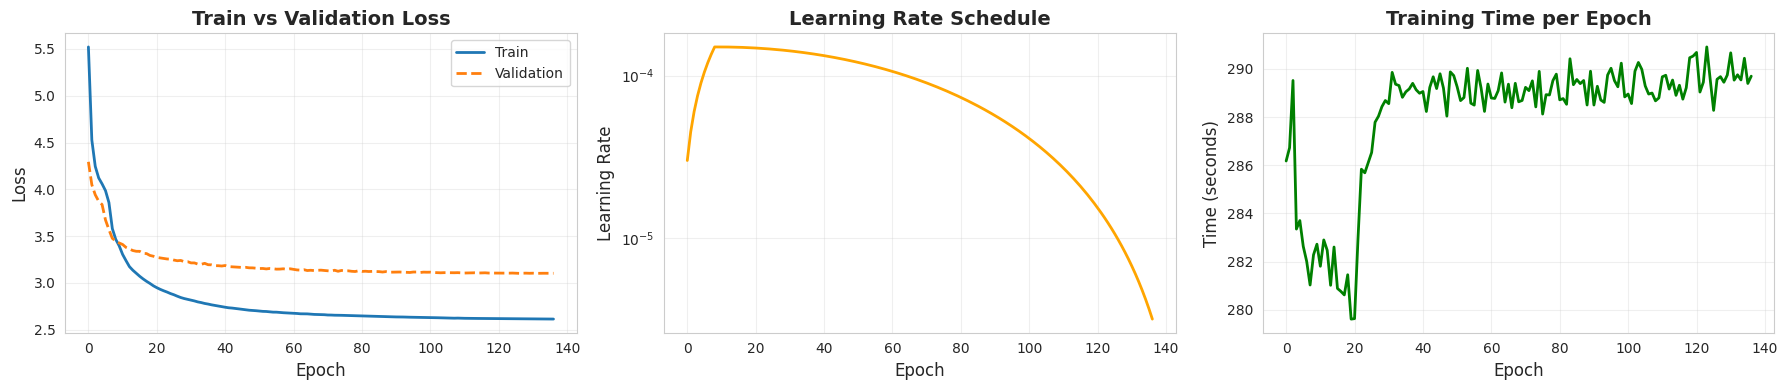


✅ Training curves saved to: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/training_curves.png


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Training & Validation loss
axes[0].plot(history['train_loss'], linewidth=2, label='Train')
axes[0].plot(history['val_loss'], linewidth=2, linestyle='--', label='Validation')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# Learning rate
axes[1].plot(history['lr'], linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Epoch time
axes[2].plot(history['epoch_time'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Training curves saved to: {save_dir / 'training_curves.png'}")

## 12. Generate Multi-Scale Embeddings

In [21]:
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm
import os

print("🔄 Generating multi-scale embeddings from NORMALIZED checkpoint...\n")

# 1. Charger le checkpoint contenant le modèle ET les stats
checkpoint_path = "/content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/best_encoder_with_norm.pt"
checkpoint = torch.load(checkpoint_path, map_location=config.device)

print(f"✅ Loaded checkpoint from: {checkpoint_path}")

# --- CORRECTION ICI : Gestion flexible des clés ---
# On cherche 'epoch' à la racine OU dans 'model_info' (au cas où)
epoch = checkpoint.get('epoch')
if epoch is None and 'model_info' in checkpoint:
    epoch = checkpoint['model_info'].get('epoch')

loss = checkpoint.get('loss')
if loss is None and 'model_info' in checkpoint:
    loss = checkpoint['model_info'].get('loss')

print(f"   Epoch: {epoch if epoch is not None else 'Unknown'}")
print(f"   Loss: {loss if loss is not None else 'Unknown'}")
# --------------------------------------------------

# 2. Restaurer les poids du modèle
# Pareil, on cherche 'model_state_dict' à la racine ou imbriqué
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
elif 'model' in checkpoint:
    model.load_state_dict(checkpoint['model'])
else:
    # Cas rare : le checkpoint est directement le state_dict
    try:
        model.load_state_dict(checkpoint)
    except:
        raise KeyError("Impossible de trouver 'model_state_dict' dans le checkpoint.")

model.eval()

# 3. Récupérer les stats de normalisation sauvegardées
# On les envoie sur le GPU pour que le calcul soit rapide
norm_mean = checkpoint['normalization']['mean'].to(config.device)
norm_std = checkpoint['normalization']['std'].to(config.device)

print(f"✅ Normalization stats loaded!")
print(f"   Mean (first 4): {norm_mean[:4].cpu().numpy()}")
print(f"   Std  (first 4): {norm_std[:4].cpu().numpy()}")

# 4. Créer le DataLoader pour tout le dataset (Train + Val)
print("\n📊 Creating full dataset loader...")
full_loader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    shuffle=False,  # CRUCIAL : Pas de shuffle pour garder l'ordre des indices
    num_workers=config.num_workers,
    pin_memory=True
)

# 5. Boucle de génération
all_embeddings = {
    'assets': [],
    'zones': [],
    'regions': [],
    'nation': [],
    'metadata': [],
}

print(f"🚀 Starting inference on {len(dataset)} graphs...")

with torch.no_grad():
    for i, batch in enumerate(tqdm(full_loader, desc="Generating embeddings")):
        batch = batch.to(config.device)

        # =========================================================
        # 🛡️ APPLIQUER LA NORMALISATION DU CHECKPOINT
        # =========================================================
        if hasattr(batch, 'x') and batch.x is not None:
            batch.x = (batch.x - norm_mean) / norm_std
        # =========================================================

        # Préparer les inputs structurels
        N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
        T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()

        # Récupérer la hiérarchie
        current_hierarchy = get_hierarchy_from_batch(batch, config.device)

        # Ajouter les self-loops (comme à l'entraînement)
        N_total = batch.x.size(0)
        edge_index_with_loops, _ = add_self_loops(batch.edge_index, num_nodes=N_total)

        # Forward Pass
        embeddings = model(
            batch.x,
            edge_index_with_loops,
            batch.node_type if hasattr(batch, "node_type") else None,
            N_base,
            T,
            hierarchy_mapping=current_hierarchy,
            zone_edges=None,
            region_edges=None,
            batch=None,
            return_sequence=True,
        )

        # Stocker les résultats (move to CPU pour éviter OOM)
        all_embeddings['assets'].append(embeddings['assets'].cpu())
        all_embeddings['zones'].append(embeddings['zones'].cpu())
        all_embeddings['regions'].append(embeddings['regions'].cpu())
        all_embeddings['nation'].append(embeddings['nation'].cpu())

        # Métadonnées pour traçabilité
        all_embeddings['metadata'].append({
            'graph_idx': i,
            'N_base': N_base,
            'T': T
        })

        # Nettoyage cache GPU périodique
        if (i + 1) % 100 == 0:
            torch.cuda.empty_cache()

# 6. Sauvegarde finale
print(f"\n💾 Saving final normalized embeddings...")

final_output_path = "/content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt"

output_data = {
    'embeddings': all_embeddings,
    'normalization_used': { # On garde une trace de ce qui a été utilisé
        'mean': norm_mean.cpu(),
        'std': norm_std.cpu()
    },
    'source_checkpoint': checkpoint_path,
    'dataset_info': {
        'total_graphs': len(dataset),
        'graph_files': [str(f) for f in graph_files]
    }
}

torch.save(output_data, final_output_path)

print(f"✅ Success! Embeddings saved to:")
print(f"   {final_output_path}")

🔄 Generating multi-scale embeddings from NORMALIZED checkpoint...

✅ Loaded checkpoint from: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/best_encoder_with_norm.pt
   Epoch: 127
   Loss: 3.101634460526544
✅ Normalization stats loaded!
   Mean (first 4): [166.28261   71.022026  85.57229   65.777725]
   Std  (first 4): [428.55096 393.32965 558.4737  450.3384 ]

📊 Creating full dataset loader...
🚀 Starting inference on 2960 graphs...


/tmp/ipython-input-1672829280.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=config.device)


Generating embeddings:   0%|          | 0/2960 [00:00<?, ?it/s]


💾 Saving final normalized embeddings...
✅ Success! Embeddings saved to:
   /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt


In [22]:
!ls -lh /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/

total 30G
-rw------- 1 root root  37M Dec 21 20:15 best_encoder.pt
-rw------- 1 root root  37M Dec 21 21:04 best_encoder_with_norm.pt
-rw------- 1 root root  37M Dec 21 18:05 checkpoint_epoch_100.pt
-rw------- 1 root root  37M Dec 21 10:53 checkpoint_epoch_10.pt
-rw------- 1 root root  37M Dec 21 18:53 checkpoint_epoch_110.pt
-rw------- 1 root root  37M Dec 21 19:41 checkpoint_epoch_120.pt
-rw------- 1 root root  37M Dec 21 20:30 checkpoint_epoch_130.pt
-rw------- 1 root root  37M Dec 21 11:40 checkpoint_epoch_20.pt
-rw------- 1 root root  37M Dec 21 12:28 checkpoint_epoch_30.pt
-rw------- 1 root root  37M Dec 21 13:16 checkpoint_epoch_40.pt
-rw------- 1 root root  37M Dec 21 14:04 checkpoint_epoch_50.pt
-rw------- 1 root root  37M Dec 21 14:52 checkpoint_epoch_60.pt
-rw------- 1 root root  37M Dec 21 15:40 checkpoint_epoch_70.pt
-rw------- 1 root root  37M Dec 21 16:29 checkpoint_epoch_80.pt
-rw------- 1 root root  37M Dec 21 17:17 checkpoint_epoch_90.pt
-rw------- 1 root root  15G De

In [24]:
import torch

def embedding_norm_stats(emb, name="embeddings"):
    """
    emb: Tensor [N, T, D] or [N, D]
    """
    if emb.dim() == 3:
        # [N, T, D] → norme par (node, time)
        norms = torch.norm(emb, dim=-1)        # [N, T]
        norms_flat = norms.reshape(-1)
    elif emb.dim() == 2:
        # [N, D]
        norms_flat = torch.norm(emb, dim=-1)
    else:
        raise ValueError(f"Unexpected embedding shape: {emb.shape}")

    print(f"\n📊 Norm stats for {name}")
    print(f"  min  : {norms_flat.min().item():.4f}")
    print(f"  mean : {norms_flat.mean().item():.4f}")
    print(f"  std  : {norms_flat.std().item():.4f}")
    print(f"  max  : {norms_flat.max().item():.4f}")

    return norms_flat


# --------- APPLY TO YOUR SAVED EMBEDDINGS ---------

def to_tensor(x):
    """Convert list of tensors or tensor to a single tensor on CPU."""
    if isinstance(x, list):
        # filter None just in case
        x = [t for t in x if t is not None]
        return torch.cat([t.detach().cpu() for t in x], dim=0)
    elif isinstance(x, torch.Tensor):
        return x.detach().cpu()
    else:
        raise TypeError(f"Unsupported embedding container: {type(x)}")

print("🚀 Computing statistics...")

if isinstance(all_embeddings, dict):
    for level, emb in all_embeddings.items():
        # --- CORRECTIF : On ignore les métadonnées ---
        if level == 'metadata':
            continue
        # ---------------------------------------------

        if emb is None or len(emb) == 0:
            continue

        # Petit try/except au cas où d'autres clés non-tensor traînent
        try:
            emb_cpu = to_tensor(emb)
            embedding_norm_stats(emb_cpu, name=level)
        except Exception as e:
            print(f"⚠️ Could not compute stats for '{level}': {e}")

else:
    emb_cpu = to_tensor(all_embeddings)
    embedding_norm_stats(emb_cpu, name="global")

🚀 Computing statistics...

📊 Norm stats for assets
  min  : 3.3654
  mean : 6.5137
  std  : 0.8502
  max  : 10.3520

📊 Norm stats for zones
  min  : 22.4934
  mean : 28.6045
  std  : 1.3886
  max  : 32.9375

📊 Norm stats for regions
  min  : 13.1425
  mean : 13.5830
  std  : 0.0902
  max  : 13.6922

📊 Norm stats for nation
  min  : 11.5005
  mean : 11.7342
  std  : 0.0899
  max  : 11.9048


In [29]:
from torch.nn.functional import cosine_similarity

# 1. Convertir la liste de tenseurs en un seul tenseur
# On utilise torch.cat pour empiler tous les batchs à la suite
if isinstance(all_embeddings["assets"], list):
    E_tensor = torch.cat(all_embeddings["assets"], dim=0)
else:
    E_tensor = all_embeddings["assets"]

# 2. Maintenant on peut faire .float() et calculer la variance
E = E_tensor.float()

print(f"Shape: {E.shape}") # Vérif (Total_Nodes, T, D)
print("Mean temporal variance:", E.var(dim=1).mean().item())

sim = cosine_similarity(E[:, :-1, :], E[:, 1:, :], dim=-1)
print("Mean cosine similarity (t,t+1):", sim.mean().item())

Shape: torch.Size([1071045, 24, 128])
Mean temporal variance: 0.08344122767448425
Mean cosine similarity (t,t+1): 0.8974586129188538


In [30]:
# Vérification de la diversité spatiale (Asset vs Asset)
# On prend un graphe au hasard et on regarde la similarité entre ses différents assets

import torch.nn.functional as F

# On prend le premier graphe (les N_base premiers noeuds)
N_assets_sample = 100 # On compare 100 assets entre eux
E_sample = E[:N_assets_sample, 0, :] # Au temps t=0

# Normalisation pour cosine similarity
E_sample_norm = F.normalize(E_sample, p=2, dim=1)

# Matrice de similarité (100x100)
sim_matrix = torch.mm(E_sample_norm, E_sample_norm.t())

# On enlève la diagonale (qui est toujours 1.0)
mask = ~torch.eye(N_assets_sample, dtype=torch.bool, device=sim_matrix.device)
mean_spatial_sim = sim_matrix[mask].mean().item()

print(f"📊 Spatial Diversity Check (Asset vs Asset):")
print(f"   Mean Cosine Sim: {mean_spatial_sim:.4f}")

if mean_spatial_sim > 0.95:
    print("⚠️ DANGER: Mode Collapse Spatial (tous les assets se ressemblent)")
elif mean_spatial_sim < 0.5:
    print("✅ EXCELLENT: Les assets sont très distincts")
else:
    print("✅ BON: Les assets partagent une structure commune mais sont distincts")

📊 Spatial Diversity Check (Asset vs Asset):
   Mean Cosine Sim: 0.3511
✅ EXCELLENT: Les assets sont très distincts
